In [1]:
!pip install --quiet sqlalchemy

In [12]:
# 1. Imports
import os
import io
import zipfile
from google.colab import files
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [13]:
# 2. Prepare folders
EXTRACT_DIR = "/content/csv_data"
DB_PATH = "/content/assignment3.db"
OUT_DIR = "/content/outputs"
os.makedirs(EXTRACT_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

In [14]:
# 3. Upload one ZIP file that contains the 5 CSV files
print("Please upload ONE ZIP file that contains these CSVs:")
print(" - medicines.csv")
print(" - suppliers.csv")
print(" - purchase_stock.csv")
print(" - pharmacy_sale.csv")
print(" - pharmacy_sale_item.csv")
print("\nSelect your ZIP file in the file dialog that appears.\n")

uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Re-run the cell and upload the ZIP file.")

zip_filename = list(uploaded.keys())[0]
print("Uploaded:", zip_filename)

Please upload ONE ZIP file that contains these CSVs:
 - medicines.csv
 - suppliers.csv
 - purchase_stock.csv
 - pharmacy_sale.csv
 - pharmacy_sale_item.csv

Select your ZIP file in the file dialog that appears.



Saving pharmacy_synth.zip to pharmacy_synth (3).zip
Uploaded: pharmacy_synth (3).zip


In [15]:
# 4. Extract the ZIP
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), "r") as z:
    z.extractall(EXTRACT_DIR)
print("Extracted to:", EXTRACT_DIR)
print("Files found:", os.listdir(EXTRACT_DIR))

Extracted to: /content/csv_data
Files found: ['streamlit_app.py', 'pharmacy_sale_item.csv', 'suppliers.csv', 'pharmacy_sale.csv', 'purchase_stock.csv', 'medicines.csv']


In [16]:
# 5. Validate required files
required_files = [
    "medicines.csv",
    "suppliers.csv",
    "purchase_stock.csv",
    "pharmacy_sale.csv",
    "pharmacy_sale_item.csv"
]
missing = [f for f in required_files if not os.path.exists(os.path.join(EXTRACT_DIR, f))]
if missing:
    raise FileNotFoundError(f"Missing required CSVs in ZIP: {missing}. Re-upload a ZIP containing all files.")



In [17]:
# 6. Load CSVs into pandas (parse dates where applicable)
print("\nLoading CSVs into pandas...")
medicines_df = pd.read_csv(os.path.join(EXTRACT_DIR, "medicines.csv"))
suppliers_df = pd.read_csv(os.path.join(EXTRACT_DIR, "suppliers.csv"))
purchase_df = pd.read_csv(os.path.join(EXTRACT_DIR, "purchase_stock.csv"), parse_dates=["purchase_date","expiry_date"], dayfirst=False, infer_datetime_format=True)
sales_df = pd.read_csv(os.path.join(EXTRACT_DIR, "pharmacy_sale.csv"), parse_dates=["sale_datetime"], dayfirst=False, infer_datetime_format=True)
sale_items_df = pd.read_csv(os.path.join(EXTRACT_DIR, "pharmacy_sale_item.csv"))

print("Row counts:")
print(" - medicines:", len(medicines_df))
print(" - suppliers:", len(suppliers_df))
print(" - purchase_stock:", len(purchase_df))
print(" - pharmacy_sale:", len(sales_df))
print(" - pharmacy_sale_item:", len(sale_items_df))


Loading CSVs into pandas...
Row counts:
 - medicines: 500
 - suppliers: 10
 - purchase_stock: 3000
 - pharmacy_sale: 20000
 - pharmacy_sale_item: 24140


In [18]:
# 7. Create SQLite DB and write tables
print("\nCreating SQLite DB and writing tables...")
engine = create_engine(f"sqlite:///{DB_PATH}", connect_args={'check_same_thread': False})
medicines_df.to_sql("Medicine", engine, if_exists="replace", index=False)
suppliers_df.to_sql("Supplier", engine, if_exists="replace", index=False)
purchase_df.to_sql("Purchase_Stock", engine, if_exists="replace", index=False)
sales_df.to_sql("Pharmacy_Sale", engine, if_exists="replace", index=False)
sale_items_df.to_sql("Pharmacy_Sale_Item", engine, if_exists="replace", index=False)
print("Database created at:", DB_PATH)


Creating SQLite DB and writing tables...
Database created at: /content/assignment3.db


In [19]:
# 8. Helper to run SQL and save CSV
def run_sql_save(sql, out_name, params=None):
    try:
        df = pd.read_sql_query(text(sql), engine, params=params)
        out_path = os.path.join(OUT_DIR, out_name + ".csv")
        df.to_csv(out_path, index=False)
        print(f"[OK] {out_name} -> {out_path} ({len(df)} rows)")
        return df
    except Exception as e:
        print(f"[ERROR] Running {out_name}: {e}")
        return pd.DataFrame()

In [20]:
# 9. SQL queries adapted to SQLite
# (1) Monthly revenue
sql_monthly = """
SELECT
  substr(s.sale_datetime,1,7) AS month,
  SUM(si.selling_price * si.sold_quantity) AS gross_revenue,
  SUM(COALESCE(si.discount_amount,0)) AS total_discount,
  SUM((si.selling_price * si.sold_quantity) * COALESCE(m.gst_percentage,0)/100.0) AS total_gst,
  SUM(si.selling_price * si.sold_quantity) - SUM(COALESCE(si.discount_amount,0))
    + SUM((si.selling_price * si.sold_quantity) * COALESCE(m.gst_percentage,0)/100.0) AS net_revenue
FROM Pharmacy_Sale s
JOIN Pharmacy_Sale_Item si ON s.sale_id = si.sale_id
LEFT JOIN Medicine m ON si.medicine_id = m.medicine_id
GROUP BY substr(s.sale_datetime,1,7)
ORDER BY month;
"""
df_monthly = run_sql_save(sql_monthly, "monthly_revenue")

[OK] monthly_revenue -> /content/outputs/monthly_revenue.csv (26 rows)


In [24]:
# (2a) Top 10 medicines by qty
sql_top_qty = """
SELECT
  COALESCE(m.medicine_id, si.medicine_id) AS medicine_id,
  COALESCE(m.name,'UNKNOWN') AS name,
  SUM(si.sold_quantity) AS total_qty_sold
FROM Pharmacy_Sale_Item si
LEFT JOIN Medicine m ON si.medicine_id = m.medicine_id
GROUP BY COALESCE(m.medicine_id, si.medicine_id), COALESCE(m.name, 'UNKNOWN')
ORDER BY total_qty_sold DESC
LIMIT 10;
"""
df_top_qty = run_sql_save(sql_top_qty, "top_medicines_qty")

[OK] top_medicines_qty -> /content/outputs/top_medicines_qty.csv (10 rows)


In [26]:
# (2b) Top 10 medicines by revenue
sql_top_rev = """
SELECT
  COALESCE(m.medicine_id, si.medicine_id) AS medicine_id,
  COALESCE(m.name,'UNKNOWN') AS name,
  SUM((si.selling_price * si.sold_quantity) - COALESCE(si.discount_amount,0)
      + (si.selling_price * si.sold_quantity) * COALESCE(m.gst_percentage,0)/100.0) AS total_net_revenue
FROM Pharmacy_Sale_Item si
LEFT JOIN Medicine m ON si.medicine_id = m.medicine_id
GROUP BY COALESCE(m.medicine_id, si.medicine_id), COALESCE(m.name, 'UNKNOWN')
ORDER BY total_net_revenue DESC
LIMIT 10;
"""
df_top_rev = run_sql_save(sql_top_rev, "top_medicines_revenue")

[OK] top_medicines_revenue -> /content/outputs/top_medicines_revenue.csv (10 rows)


In [27]:
# (3) Near-expiry within next 60 days
sql_near_expiry = """
SELECT
  ps.batch_no,
  ps.medicine_id,
  COALESCE(m.name,'UNKNOWN') AS medicine_name,
  ps.expiry_date,
  ps.purchase_quantity,
  COALESCE(SUM(si.sold_quantity),0) AS sold_qty,
  ps.purchase_quantity - COALESCE(SUM(si.sold_quantity),0) AS remaining_qty
FROM Purchase_Stock ps
LEFT JOIN Pharmacy_Sale_Item si ON ps.batch_no = si.batch_no AND ps.medicine_id = si.medicine_id
LEFT JOIN Medicine m ON ps.medicine_id = m.medicine_id
WHERE ps.expiry_date BETWEEN date('now') AND date('now','+60 days')
GROUP BY ps.batch_no, ps.medicine_id, m.name, ps.expiry_date, ps.purchase_quantity
HAVING ps.purchase_quantity - COALESCE(SUM(si.sold_quantity),0) > 0
ORDER BY ps.expiry_date ASC;
"""
df_near = run_sql_save(sql_near_expiry, "near_expiry_batches")

[OK] near_expiry_batches -> /content/outputs/near_expiry_batches.csv (163 rows)


In [28]:
# (4) Supplier performance
sql_supplier = """
WITH supplier_stats AS (
  SELECT
    ps.supplier_id,
    SUM(ps.purchase_quantity) AS total_qty_supplied,
    SUM(ps.purchase_quantity * ps.purchase_price) AS total_purchase_value,
    COUNT(DISTINCT ps.medicine_id) AS distinct_medicines_supplied,
    AVG(ps.purchase_price) AS avg_purchase_price
  FROM Purchase_Stock ps
  GROUP BY ps.supplier_id
)
SELECT
  ss.supplier_id,
  COALESCE(s.supplier_name,'UNKNOWN') AS supplier_name,
  ss.total_qty_supplied,
  ss.total_purchase_value,
  ss.distinct_medicines_supplied,
  ss.avg_purchase_price
FROM supplier_stats ss
LEFT JOIN Supplier s ON ss.supplier_id = s.supplier_id
ORDER BY ss.total_purchase_value DESC;
"""
df_supplier = run_sql_save(sql_supplier, "supplier_performance")

[OK] supplier_performance -> /content/outputs/supplier_performance.csv (10 rows)


In [30]:
# (5) Margin analysis per medicine
sql_margin = """
SELECT
  COALESCE(m.medicine_id, si.medicine_id) AS medicine_id,
  COALESCE(m.name,'UNKNOWN') AS name,
  SUM((si.selling_price - COALESCE(ps.purchase_price,0)) * si.sold_quantity) AS total_gross_profit,
  SUM(si.sold_quantity) AS total_units_sold,
  CASE WHEN SUM(si.selling_price * si.sold_quantity)=0 THEN NULL
       ELSE (SUM((si.selling_price - COALESCE(ps.purchase_price,0)) * si.sold_quantity)
            / SUM(si.selling_price * si.sold_quantity)) * 100.0 END AS avg_margin_pct
FROM Pharmacy_Sale_Item si
LEFT JOIN Purchase_Stock ps ON si.batch_no = ps.batch_no AND si.medicine_id = ps.medicine_id
LEFT JOIN Medicine m ON si.medicine_id = m.medicine_id
GROUP BY COALESCE(m.medicine_id, si.medicine_id), COALESCE(m.name, 'UNKNOWN')
ORDER BY avg_margin_pct DESC;
"""
df_margin = run_sql_save(sql_margin, "margin_by_medicine")

[OK] margin_by_medicine -> /content/outputs/margin_by_medicine.csv (500 rows)


In [31]:
# (6) Revenue by customer type & payment mode (sample date range)
start_date = "2023-01-01"
end_date = "2025-12-31"
sql_rev_cust = f"""
SELECT
  s.customer_type,
  s.payment_mode,
  SUM(si.selling_price * si.sold_quantity) AS gross_revenue,
  SUM(COALESCE(si.discount_amount,0)) AS total_discount,
  SUM((si.selling_price * si.sold_quantity) * COALESCE(m.gst_percentage,0)/100.0) AS total_gst,
  SUM(si.selling_price * si.sold_quantity) - SUM(COALESCE(si.discount_amount,0))
    + SUM((si.selling_price * si.sold_quantity) * COALESCE(m.gst_percentage,0)/100.0) AS net_revenue
FROM Pharmacy_Sale s
JOIN Pharmacy_Sale_Item si ON s.sale_id = si.sale_id
LEFT JOIN Medicine m ON si.medicine_id = m.medicine_id
WHERE s.sale_datetime BETWEEN '{start_date}' AND '{end_date}'
GROUP BY s.customer_type, s.payment_mode
ORDER BY net_revenue DESC;
"""
df_rev_cust = run_sql_save(sql_rev_cust, "revenue_by_customer_payment")


[OK] revenue_by_customer_payment -> /content/outputs/revenue_by_customer_payment.csv (12 rows)


In [33]:
# (7) Stock movement (opening/purchases/sales/closing)
sql_stock_movement = f"""
WITH purchases_before AS (
  SELECT medicine_id, SUM(purchase_quantity) AS purchased_before
  FROM Purchase_Stock
  WHERE purchase_date < '{start_date}'
  GROUP BY medicine_id
),
sales_before AS (
  SELECT si.medicine_id, SUM(si.sold_quantity) AS sold_before
  FROM Pharmacy_Sale_Item si
  JOIN Pharmacy_Sale s ON si.sale_id = s.sale_id
  WHERE s.sale_datetime < '{start_date}'
  GROUP BY si.medicine_id
),
purchases_during AS (
  SELECT medicine_id, SUM(purchase_quantity) AS purchased_during
  FROM Purchase_Stock
  WHERE purchase_date BETWEEN '{start_date}' AND '{end_date}'
  GROUP BY medicine_id
),
sales_during AS (
  SELECT si.medicine_id, SUM(si.sold_quantity) AS sold_during
  FROM Pharmacy_Sale_Item si
  JOIN Pharmacy_Sale s ON si.sale_id = s.sale_id
  WHERE s.sale_datetime BETWEEN '{start_date}' AND '{end_date}'
  GROUP BY si.medicine_id
)
SELECT
  COALESCE(m.medicine_id, pb.medicine_id) AS medicine_id,
  COALESCE(m.name,'UNKNOWN') AS name,
  COALESCE(pb.purchased_before,0) - COALESCE(sb.sold_before,0) AS opening_stock,
  COALESCE(pd.purchased_during,0) AS purchases_during_period,
  COALESCE(sd.sold_during,0) AS sales_during_period,
  (COALESCE(pb.purchased_before,0) - COALESCE(sb.sold_before,0)
    + COALESCE(pd.purchased_during,0) - COALESCE(sd.sold_during,0)) AS closing_stock
FROM Medicine m
LEFT JOIN purchases_before pb ON m.medicine_id = pb.medicine_id
LEFT JOIN sales_before sb ON m.medicine_id = sb.medicine_id
LEFT JOIN purchases_during pd ON m.medicine_id = pd.medicine_id
LEFT JOIN sales_during sd ON m.medicine_id = sd.medicine_id
ORDER BY name;
"""
df_stock = run_sql_save(sql_stock_movement, "stock_movement")

[OK] stock_movement -> /content/outputs/stock_movement.csv (500 rows)


In [34]:
# (9) Helper: unmatched sale items (sample)
sql_unmatched = """
SELECT si.sale_item_id, si.sale_id, si.medicine_id, si.batch_no, si.sold_quantity, si.selling_price
FROM Pharmacy_Sale_Item si
LEFT JOIN Purchase_Stock ps ON si.batch_no = ps.batch_no AND si.medicine_id = ps.medicine_id
WHERE ps.purchase_id IS NULL
LIMIT 200;
"""
df_unmatched = run_sql_save(sql_unmatched, "unmatched_sales_items_sample")


[OK] unmatched_sales_items_sample -> /content/outputs/unmatched_sales_items_sample.csv (78 rows)



Generating plots...


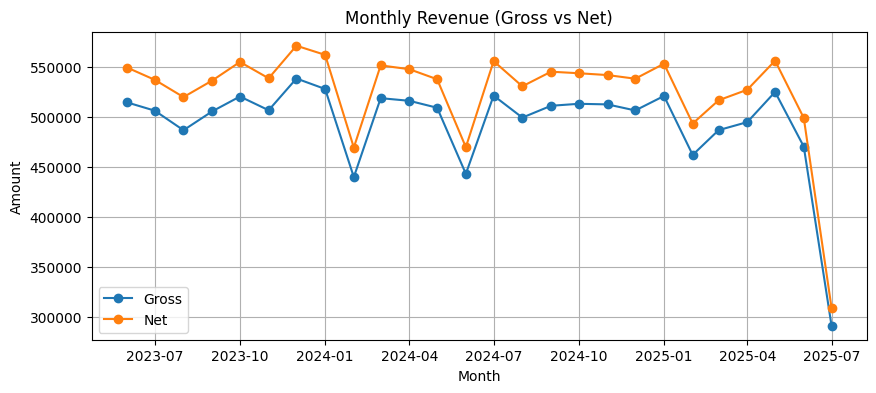

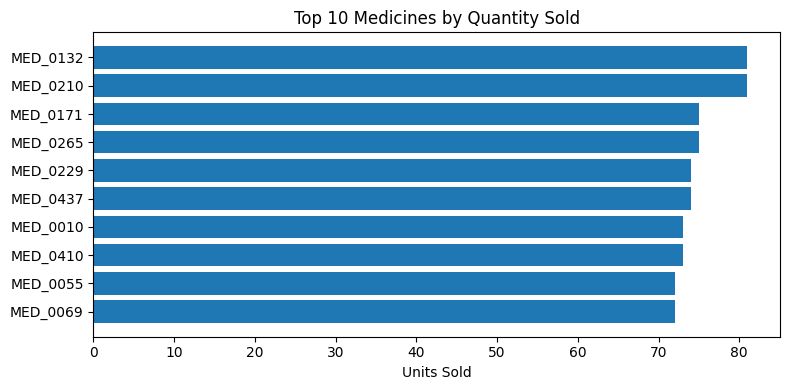

In [35]:
# 10. Basic inline plots
print("\nGenerating plots...")

# Monthly revenue plot
try:
    if not df_monthly.empty:
        df_monthly_plot = df_monthly.copy()
        df_monthly_plot['month_dt'] = pd.to_datetime(df_monthly_plot['month'] + "-01")
        plt.figure(figsize=(10,4))
        plt.plot(df_monthly_plot['month_dt'], df_monthly_plot['gross_revenue'], marker='o', label='Gross')
        plt.plot(df_monthly_plot['month_dt'], df_monthly_plot['net_revenue'], marker='o', label='Net')
        plt.title("Monthly Revenue (Gross vs Net)")
        plt.xlabel("Month")
        plt.ylabel("Amount")
        plt.legend()
        plt.grid(True)
        plt.show()
except Exception as e:
    print("Could not plot monthly revenue:", e)

# Top medicines by qty bar chart
try:
    if not df_top_qty.empty:
        plt.figure(figsize=(8,4))
        plt.barh(df_top_qty['name'][::-1], df_top_qty['total_qty_sold'][::-1])
        plt.title("Top 10 Medicines by Quantity Sold")
        plt.xlabel("Units Sold")
        plt.tight_layout()
        plt.show()
except Exception as e:
    print("Could not plot top medicines:", e)


In [37]:
# 11. Summary of outputs
print("\nAll CSV outputs saved to:", OUT_DIR)
for f in sorted(os.listdir(OUT_DIR)):
    print(" -", f)

print("\nYou can download files from the Colab file browser (left panel) or use files.download().")
print("Done.")


All CSV outputs saved to: /content/outputs
 - margin_by_medicine.csv
 - monthly_revenue.csv
 - near_expiry_batches.csv
 - revenue_by_customer_payment.csv
 - stock_movement.csv
 - supplier_performance.csv
 - top_medicines_qty.csv
 - top_medicines_revenue.csv
 - unmatched_sales_items_sample.csv

You can download files from the Colab file browser (left panel) or use files.download().
Done.
